## Movie Genre Multi-Label Classification with MobileViT

[Korean](01_garbage.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Image Classification 모델을 학습하는 과정을 다루고 있습니다.


## Process
1. Scoping : 문제정의
2. Data : 데이터 수집, 분석
3. Modeling : 적합한 모델 선정
4. Training : 데이터 학습
5. Analysis : 모델 분석 및 평가

## 1. Scoping (문제 정의)

- Garbage Image가 주어졌을 때 해당 Image가 어떤 Garbage인지를 분류합니다.
  - Input : Image File
  - Output : Garbage Class

## 2. Data (데이터 수집 및 분석)
- 데이터 수집은 최초 한번으로 끝나는 것이 아닌 이후 모델링, 학습, 평가 기간동안 계속해서 염두해야 합니다.
- 데이터 분석은 정량적, 정성적으로 살펴보아야 합니다.

### 2.1. Summary

- Dataset Download : https://www.kaggle.com/datasets/engalaasamir/multilabel-image-movies-genre
- Dataset Tree
    ```
        movie_genre
        ├─Images : 7867 files / 16874 labels
        ...
        (After Postprocessing)
        ├─train  : 4346 files / 10157 labels
        ├─val    : 1451 files /  3374 labels
        └─test   : 1450 files /  3343 labels
    ```
- Dataset Configuration
    - The number of images : 7247 files
        - train.csv 파일에 7255 개 file에 대한 annotation만 존재해 movie_genre와 train.csv의 교집합만 데이터로 사용
    - The number of labels : 16874 labels
    - The number of classes : 25
    - The number of images for each class
        |Class|Train|Val|Test|
        |------|---|---|---|
        |Action|807|260|276|
        |Adventure|526|181|163|
        |Animation|145|37|62|
        |Biography|261|103|77|
        |Comedy|1763|573|564|
        |Crime|721|221|234|
        |Documentary|399|125|128|
        |Drama|2146|752|721|
        |Family|263|75|96|
        |Fantasy|296|81|90|
        |History|134|52|38|
        |Horror|300|109|94|
        |Music|183|69|53|
        |Musical|61|22|14|
        |Mystery|275|89|90|
        |N/A|5|1|4|
        |News|14|5|2|
        |Reality-TV|2|0|0|
        |Romance|791|261|282|
        |Sci-Fi|237|75|87|
        |Short|30|10|6|
        |Sport|144|42|35|
        |Thriller|534|194|190|
        |War|89|27|28|
        |Western|31|10|9|

### 2.2. Data Analysis

실제 데이터에 어떤 이미지가 있는지 살펴봅니다.

(Optional) gdrive에 있는 데이터를 mount 할때 아래와 같이 mount 후 데이터 경로를 지정해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dir_main = "/content/gdrive/MyDrive/dataset/movie_genre/"

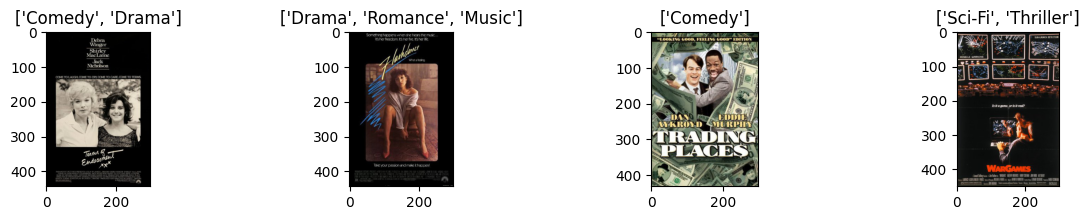

In [ ]:
import os
import matplotlib.pyplot as plt
import csv
import numpy as np
from PIL import Image

def read_csv(dir_name):
    with open(dir_name,'r') as f:
        rdr = csv.reader(f)
        lines = [line for line in rdr]
    return lines[0], np.array(lines[1:])

dir_main = "../../../data/movie_genre/"
_, annotations = read_csv(os.path.join(dir_main, 'train.csv'))

n_show = 4
fig, axes = plt.subplots(nrows=1, ncols=n_show, figsize=(15,2))
for idx, (img_name, genre) in enumerate(annotations[:, 0:2][:n_show]):
    image = Image.open(os.path.join(dir_main, "Images", img_name)+".jpg")
    axes[idx].set_title(genre)
    axes[idx].imshow(image)

### 2.3. Preprocessing dataset for train, validation and test

#### Preprare the dataset

In [ ]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
np.random.seed(724)

def read_csv(dir_name):
    with open(dir_name,'r') as f:
        rdr = csv.reader(f)
        lines = [line for line in rdr]
    return lines[0], np.array(lines[1:])

dir_main = "../../../data/movie_genre/"
column, annotations = read_csv(os.path.join(dir_main, 'train.csv'))

classes = column[2:] # 1st : 'Id', 2nd : 'Genre'
images = annotations[:,0]

x = [os.path.join(dir_main, 'Images', image) + ".jpg" for image in images]
y = [list(map(int, label)) for label in annotations[:,2:]]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=724)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5, random_state=724)

In [ ]:
def create_symlink(x_target, name='train'):
    for x in x_target:
        src = os.path.abspath(x)
        dst = src.replace("Images", name)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        if not os.path.exists(dst):
            os.symlink(src, dst)

create_symlink(x_train, "train")
create_symlink(x_test, "test")
create_symlink(x_val, "val")

def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y_list in ys:
        for y in [classes[idx] for idx, y in enumerate(y_list) if y==1]:
            if y not in cls_cnt.keys():
                cls_cnt[y]=0
            cls_cnt[y]+=1
    if cls not in cls_cnt.keys():
        return 0
    return cls_cnt[cls]

print(f"Class\t\tTrain\tVal\tTest\n")
for cls in classes:
    print(f"{cls:10}\t{get_numbers(y_train, cls)}\t{get_numbers(y_val, cls)}\t{get_numbers(y_test, cls)}")

Class		Train	Val	Test

Action    	807	260	276
Adventure 	526	181	163
Animation 	145	37	62
Biography 	261	103	77
Comedy    	1763	573	564
Crime     	721	221	234
Documentary	399	125	128
Drama     	2146	752	721
Family    	263	75	96
Fantasy   	296	81	90
History   	134	52	38
Horror    	300	109	94
Music     	183	69	53
Musical   	61	22	14
Mystery   	275	89	90
N/A       	5	1	4
News      	14	5	2
Reality-TV	2	0	0
Romance   	791	261	282
Sci-Fi    	237	75	87
Short     	30	10	6
Sport     	144	42	35
Thriller  	534	194	190
War       	89	27	28
Western   	31	10	9


### 2.4. Create DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset
from glob import glob


def read_csv(dir_name):
    with open(dir_name,'r') as f:
        rdr = csv.reader(f)
        lines = [line for line in rdr]
    return lines[0], np.array(lines[1:])

class MovieGenreDataset(Dataset): 
    def __init__(self, dir_main, source, tr):
        self.dir_dataset = os.path.abspath(os.path.join(dir_main, source))
        self.filelist = glob(self.dir_dataset + f'/*.jpg')
        assert len(self.filelist)!=0, f"{self.dir_dataset + f'/*.jpg'} is empty"

        column, annotations = read_csv(os.path.join(dir_main, 'train.csv'))
        self.classes = column[2:]
        self.find_label = {f"{annotation[0]}.jpg":np.array(list(map(int, annotation[2:]))) for annotation in annotations}
        self.tr = tr

    def get_image(self, filename):
        img = Image.open(filename).convert("RGB")
        img = self.tr(img)
        return img

    def get_label(self, filename):
        label = self.find_label[os.path.basename(filename)]
        return torch.from_numpy(label).type(torch.FloatTensor)

    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label

    def __len__(self): 
        return len(self.filelist)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# print(model.default_cfg['mean']) # 'mean': (0.485, 0.456, 0.406)
# print(model.default_cfg['std']) # 'std': (0.229, 0.224, 0.225)
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_tr = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

test_tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])
train_ds = MovieGenreDataset(dir_main, "train", train_tr)
val_ds = MovieGenreDataset(dir_main, "val", test_tr)
test_ds = MovieGenreDataset(dir_main, "test", test_tr)

train_dl = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=4)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### 3. Modeling

#### 3.1. Select Model - Vision Transformer

MobileViT: Light-weight, General-purpose, and Mobile-friendly Vision Transformer ([Paper](https://arxiv.org/abs/2110.02178)) 이란?
MobileViT (Mobile Vision Transformer)은 경량화된 모바일 기기에서도 효율적으로 실행 가능한 Vision Transformer 기반의 이미지 분류 모델입니다. 

MobileViT의 전신이 되는 Vision Transformer의 특징을 먼저 살펴보도록 하겠습니다.

<center><img src = "https://drive.google.com/uc?id=1Ir6hm-UtAuKWuyyrHu86CA2iQ_cUwGkD"  height = 300> </center>

1. Vision Transformer는 이미지 분류에 대한 전통적인 CNN 기반 모델 대신 self-attention mechanism을 사용하는 새로운 딥러닝 모델입니다. 이 모델은 이전에 자연어 처리에서 널리 사용되어 온 transformer 구조를 영상 처리에 적용한 것입니다. 이 모델의 특징은 다음과 같습니다:

2. Self-attention mechanism : Vision Transformer 모델은 각 이미지 패치를 처리하기 위해 self-attention mechanism을 사용합니다. 이는 입력 이미지를 작은 패치로 분할하고, 이러한 패치를 입력으로 사용하여 transformer encoder에서 self-attention을 수행합니다. 이렇게 함으로써 이미지의 각 패치가 서로 다른 패치와 어떻게 상호 작용하는지에 대한 정보를 효과적으로 모델링할 수 있습니다.

3. 이미지 분할 : Vision Transformer 모델은 입력 이미지를 작은 패치로 분할합니다. 이를 통해 모델은 전체 이미지를 한 번에 처리하는 대신, 각 패치를 독립적으로 처리할 수 있습니다. 이러한 방식은 모델의 계산 복잡도를 줄이면서도 이미지의 전체적인 구조를 보존할 수 있습니다. 또한, 이 모델은 다른 모델 아키텍처와 함께 사용될 수 있으며, 효과적인 전이 학습을 통해 다른 분야에서 사용될 수 있습니다.

4. 모듈러 구조 : Vision Transformer 모델은 transformer encoder와 MLP (Multi-Layer Perceptron) decoder로 구성됩니다. 이 모듈러 구조를 사용하여, 모델을 더 쉽게 수정하고 조정할 수 있습니다.

<center><img src = "https://drive.google.com/uc?id=14bTmSsBBwI_cpJUgm6FWHrqb7wH5yaP0"  height = 300> </center>

MobileViT는 ViT(Vision Transformer)와의 차이를 통해 좀더 살펴보겠습니다. 우선 두 모델 모두 Transformer 아키텍처를 기반으로 한 딥러닝 모델입니다. 하지만 MobileViT은 모바일 기기에서도 빠르고 경량화된 실행이 가능하도록 최적화된 구조를 가지고 있습니다. 이에 비해 ViT는 컴퓨팅 리소스가 더 많은 환경에서 높은 성능을 발휘합니다.

1. MobileViT Block: MobileViT은 ViT에서 사용되는 큰 어텐션 헤드를 작은 어텐션 헤드로 대체하여 모델의 크기를 줄이고, Depthwise Separable Convolution과 Pointwise Convolution 등의 경량화된 레이어를 사용하여 모바일 기기에서도 빠른 실행이 가능하도록 최적화된 구조를 가지고 있습니다.

    <center><img src = "https://drive.google.com/uc?id=1zEwazHYt1L1HELemzTx9f9uwPtUpJur8"  height = 300> </center>

    - Depthwise Separable Convolution Block: 이 블록은 입력 데이터를 Depthwise Separable Convolution(깊이별 분리 합성곱)을 통해 처리합니다. Depthwise Separable Convolution은 컨볼루션 연산을 Depthwise Convolution(깊이별 합성곱)과 Pointwise Convolution(점별 합성곱)으로 분리하여 연산량을 크게 줄일 수 있는 방법입니다. 이를 통해 모델의 크기와 실행 속도를 줄일 수 있습니다.

    - Self-Attention Block: 이 블록은 입력 데이터에 Self-Attention 메커니즘을 적용합니다. Self-Attention은 입력 시퀀스에서 각 요소들 간의 상호작용을 고려하여 정보를 추출하는 메커니즘입니다. 이를 통해 입력 데이터의 중요한 부분에 집중하고, 불필요한 정보를 제거하여 모델의 성능을 개선할 수 있습니다.

    <center><img src = "https://drive.google.com/uc?id=1gBK9jneRRMc8bIA2s7KvP4fpu6dezqT1"  height = 300> </center>

2. 메모리 효율: MobileViT는 ViT와 비교하여 모델의 크기가 작고, 경량화된 구조를 가지기 때문에 더 적은 컴퓨팅 리소스를 사용하여 실행할 수 있습니다. 이에 따라 모바일 기기에서도 높은 성능을 발휘할 수 있습니다. 하지만 ViT는 모델의 크기가 크고, 보다 복잡한 구조를 가지기 때문에 더 높은 성능을 보입니다. 따라서, MobileViT는 모바일 기기에서 경량화된 실행이 가능하도록 최적화된 모델이며, ViT는 더 큰 컴퓨팅 리소스에서 높은 성능을 발휘할 수 있는 모델입니다.

    <center><img src = "https://drive.google.com/uc?id=1GdQKpip31KRTnaZ-1H59StTMDe3z01w0"  height = 300> </center>

3. 다양한 데이터셋에서 우수한 성능: MobileViT은 다양한 이미지 분류 데이터셋에서 우수한 성능을 보입니다. 예를 들어, ImageNet 데이터셋에서 MobileViT-Slim은 Top-1 정확도 77.1%, MobileViT-Lite는 Top-1 정확도 73.6%를 달성하였습니다. 이는 경량화된 모델임에도 불구하고, 대부분의 모델 크기가 큰 Vision Transformer 모델들보다 높은 성능을 보인다는 것을 의미합니다.


#### 3.2. Package Installation

아래 package를 설치 합니다.
- [timm](https://github.com/rwightman/pytorch-image-models), [opencv](https://github.com/opencv/opencv-python), [sklearn](https://scikit-learn.org/stable/index.html)

```
    # install dependancy
    pip install timm
    pip install opencv-python
    pip install scikit-learn
    # pip install -r requirements.txt
```

#### 3.3. Loading Model

Timm에는 기존에 학습된 여러 pretrained 모델을 제공합니다.

In [ ]:
import timm

print(f"The number of pretrained models : {len(timm.list_models('*', pretrained=True))}")
timm.list_models('mobilevitv2*', pretrained=True)

The number of pretrained models : 770


['mobilevitv2_050',
 'mobilevitv2_075',
 'mobilevitv2_100',
 'mobilevitv2_125',
 'mobilevitv2_150',
 'mobilevitv2_150_384_in22ft1k',
 'mobilevitv2_150_in22ft1k',
 'mobilevitv2_175',
 'mobilevitv2_175_384_in22ft1k',
 'mobilevitv2_175_in22ft1k',
 'mobilevitv2_200',
 'mobilevitv2_200_384_in22ft1k',
 'mobilevitv2_200_in22ft1k']

In [ ]:
model = timm.create_model('mobilevitv2_100', pretrained=True)
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-mvit-weights/mobilevitv2_100-e464ef3b.pth',
 'num_classes': 1000,
 'input_size': (3, 256, 256),
 'pool_size': (8, 8),
 'crop_pct': 0.888,
 'interpolation': 'bicubic',
 'mean': (0.0, 0.0, 0.0),
 'std': (1.0, 1.0, 1.0),
 'first_conv': 'stem.conv',
 'classifier': 'head.fc',
 'fixed_input_size': False,
 'architecture': 'mobilevitv2_100'}

In [ ]:
model = timm.create_model('mobilevitv2_100', pretrained=True, num_classes=len(classes), global_pool='avg')
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 25])

In [ ]:
import timm
import torch.nn as nn
import torch.nn.functional as F

class MobileViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('mobilevitv2_100', pretrained=True, num_classes=len(classes), global_pool='avg')
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = MobileViT()
# to_device(model, device)

In [ ]:
import pickle
import os
import torch.nn as nn

class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        self.history = history
        self.save_path = save_path
        self.loss = nn.MultiLabelSoftMarginLoss()
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    def accuracy(self, outputs, labels):
        outputs = (outputs > 0.5).clone().detach()
        return torch.tensor(torch.sum(outputs == labels).item() / (len(labels)*len(labels[0])))

    @torch.no_grad()
    def validation(self, batch):
        images, labels = batch 
        out = model(images)
        acc = self.accuracy(out, labels)
        loss = self.loss(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @torch.no_grad()
    def evaluation(self, model, data_loader):
        model.eval()
        outputs = [self.validation(batch) for batch in data_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    def logging(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        self.history.append(result)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

train_helper = TrainHelper()

In [ ]:
train_helper.evaluation(model, val_dl)

{'val_loss': 0.92804, 'val_acc': 0.52332}

## 4.Training

In [ ]:
from tqdm import tqdm

epochs = 3
optimizer = torch.optim.Adam(model.parameters(), 5.5e-5)
val_acc_best = 0
save_model_path = "./ckpt/"
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    for batch in tqdm(train_dl):
        inputs, targets = batch
        outputs = model(inputs)
        loss = train_helper.loss(outputs, targets)

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    result = train_helper.evaluation(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()

    # Save the best model
    if result['val_acc'] >= val_acc_best:
        val_acc_best = result['val_acc']
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)

100%|██████████| 80/80 [14:05<00:00, 10.56s/it]


Saved PyTorch Model State to ./ckpt/best_ep_0_0.65897.pt
Epoch 0: train_loss: 0.9256, val_loss: 0.9228, val_acc: 0.6590


100%|██████████| 80/80 [14:07<00:00, 10.60s/it]


Saved PyTorch Model State to ./ckpt/best_ep_1_0.69976.pt
Epoch 1: train_loss: 0.9183, val_loss: 0.9115, val_acc: 0.6998


100%|██████████| 80/80 [20:07<00:00, 15.10s/it]


Saved PyTorch Model State to ./ckpt/best_ep_2_0.77875.pt
Epoch 2: train_loss: 0.9038, val_loss: 0.8934, val_acc: 0.7788


##### Train & Validation Losses

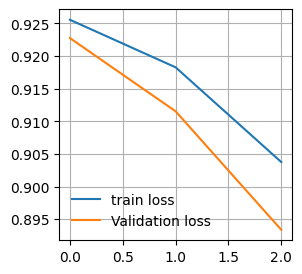

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

##### Accuracy

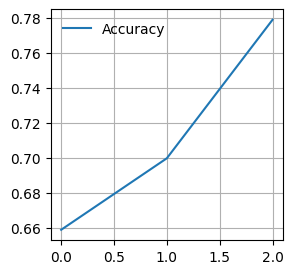

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc = [history['val_acc'] for history in train_helper.history]
plt.plot(val_acc, label='Accuracy')
plt.grid()
plt.legend(frameon=False)

## 5. Analysis

#### Load Trained Model

In [ ]:
import torch

model=MobileViT()
model.load_state_dict(torch.load("./ckpt/best_ep_2_0.77875.pt", map_location='cpu'))

<All keys matched successfully>

In [ ]:
# Recovery of normalized image dataset for visualization
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

결과 출력을 통해 모델의 성능과 적정 Threshold를 파악하여 사용합니다.

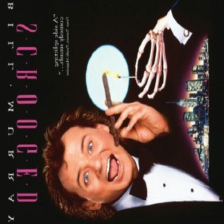

# Prediction
Action (0.6001) Crime (0.5947) Drama (0.5707) Horror (0.5982) Mystery (0.5801) Sci-Fi (0.5327) Thriller (0.6964) 

# Ground Truth
Comedy Drama Fantasy 

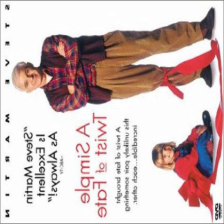

# Prediction
Comedy (0.9521) Family (0.5514) Romance (0.7734) 

# Ground Truth
Comedy Drama 

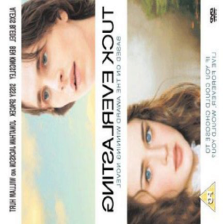

# Prediction
Biography (0.5140) Drama (0.6974) Romance (0.6595) 

# Ground Truth
Drama Family Romance 

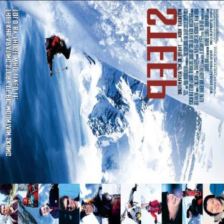

# Prediction
Action (0.7588) Adventure (0.7238) Animation (0.6165) Documentary (0.5345) Family (0.5498) Fantasy (0.5746) Horror (0.5788) Sci-Fi (0.5860) Sport (0.5281) Thriller (0.6103) War (0.5066) 

# Ground Truth
Documentary Sport 

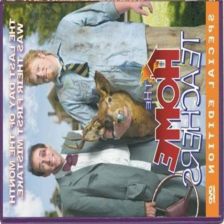

# Prediction
Adventure (0.5916) Animation (0.5882) Comedy (0.9216) Family (0.6292) Romance (0.5999) Sport (0.5030) 

# Ground Truth
Comedy 

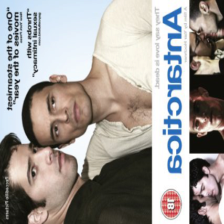

# Prediction
Comedy (0.8970) Drama (0.5887) Romance (0.8204) 

# Ground Truth
Drama Romance 

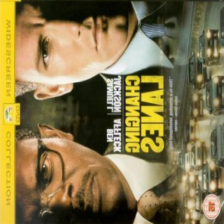

# Prediction
Action (0.6543) Biography (0.5180) Crime (0.5662) Documentary (0.5119) Drama (0.5855) Horror (0.5992) Mystery (0.5604) Sci-Fi (0.5423) Thriller (0.6785) 

# Ground Truth
Drama Thriller 

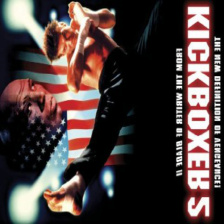

# Prediction
Action (0.7155) Adventure (0.5372) Crime (0.6093) Documentary (0.5324) Drama (0.5212) Fantasy (0.5350) Horror (0.6711) Mystery (0.6041) Sci-Fi (0.6034) Thriller (0.7542) 

# Ground Truth
Action Sport 

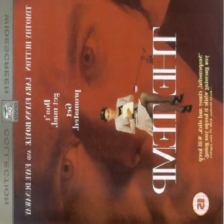

# Prediction
Biography (0.5050) Crime (0.5803) Drama (0.6655) Horror (0.5328) Mystery (0.5412) Thriller (0.6326) 

# Ground Truth
Drama Thriller 

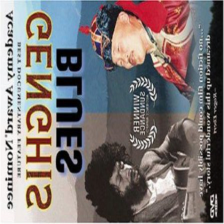

# Prediction
Action (0.5165) Adventure (0.5190) 

# Ground Truth
Documentary 

In [ ]:
from IPython.display import display
from PIL import Image
cnt = 10
for data in test_dl:
    if cnt==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    preds = (results > 0.5).clone().detach().numpy().astype(float)
    confs = results.detach().numpy()
    gts = label_batch.numpy()

    for img, p, conf, g in zip(img_batch, preds, confs, label_batch):
        if cnt <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        display(x)
        print(f"# Prediction")
        p_idx = np.where(p == 1)[0]
        g_idx = np.where(g == 1)[0]
        for idx in p_idx:
            print(f"{test_ds.classes[idx]} ({conf[idx]:0.4f})", end=" ")
        print(f"\n\n# Ground Truth")
        for idx in g_idx:
            print(f"{test_ds.classes[idx]}", end=" ")
        cnt -= 1